## Imports

In [1]:
import tensorflow as tf
from glob import glob
from os.path import join
from tensorflow.keras import layers, models
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import imports.GDL_layers as GDL_layers
from imports.GDL_model import gdl_model, CNN_model
import copy, gc
import seaborn as sns

from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler

2022-11-16 13:38:42.216866: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
ev_ds = xr.open_dataset('data/ev_ds.nc')

In [3]:
ev_ds

<xarray.Dataset>
Dimensions:                 (model: 6, test_sample: 6236, maj_min: 2)
Coordinates:
  * model                   (model) int64 0 1 2 3 4 5
  * test_sample             (test_sample) int64 0 1 2 3 ... 6232 6233 6234 6235
  * maj_min                 (maj_min) object 'major axis' 'minor axis'
Data variables:
    cnn_ensemble_mu         (model, test_sample, maj_min) float64 ...
    cnn_ensemble_sigma      (model, test_sample, maj_min) float64 ...
    aug_cnn_ensemble_mu     (model, test_sample, maj_min) float64 ...
    aug_cnn_ensemble_sigma  (model, test_sample, maj_min) float64 ...

## Load data

In [2]:
# Find a list of all the datafiles
patch_path = "/glade/scratch/lverhoef/WRF_all/track_data_hrrr_3km_nc_refl/"
patch_files = sorted(glob(join(patch_path, "*.nc")))
csv_path = "/glade/scratch/lverhoef/WRF_all/track_data_hrrr_3km_csv_refl/"
csv_files = sorted(glob(join(csv_path, "track_step_*.csv")))

In [3]:
ds = xr.open_mfdataset(patch_files, combine='nested', concat_dim='p', combine_attrs='drop_conflicts')
ds['date'] = (('p'), [str(x).split("T")[0] for x in ds['time'].values])

In [4]:
flat_seed = 1000
gsp = GroupShuffleSplit(n_splits=1, random_state = flat_seed, train_size=.9)
splits = list(gsp.split(ds["REFL_COM_curr"], groups = ds["date"]))
train_index, test_index = splits[0]
input_train_full, input_test = ds.isel(p=train_index), ds.isel(p=test_index)

In [5]:
csv_variables = ["major_axis_length", "minor_axis_length"]
csv_data_list = []
for csv_file in csv_files:
    csv_ds = pd.read_csv(csv_file)
    csv_data_list.append(csv_ds[csv_variables].to_xarray().rename({'index': 'p'}))
csv_ds = xr.concat(csv_data_list, dim='p').to_array().transpose()

In [6]:
output_train_full, output_test = csv_ds.isel(p=train_index), csv_ds.isel(p=test_index)

In [7]:
n_models = 6
n_splits = 6

In [8]:
class ImageScaler(object):
    
    def __init__(self, with_mean=True, with_std=True, copy=True):
        self.with_mean = with_mean
        self.with_std = with_std
        self.copy = copy
        
    def fit(self, X, y=None):
        self.mean_ = X.mean()
        self.std_ = X.std()
        return None
        
    def transform(self, X, copy=None):
        try:
            self.mean_
            self.std_
        except NameError:
            print('Must run .fit method first')
        if copy is None:
            copy = self.copy
        if self.with_mean:
            X -= self.mean_
        if self.with_std:
            X /= self.std_
        return X

    def fit_transform(self, X, y=None):
        self.fit(X)
        return self.transform(X)
    
    def inverse_transform(self, X, y=None):
        try:
            self.mean_
            self.std_
        except NameError:
            print('Must run .fit method first')
        if self.with_std:
            X *= self.std_
        if self.with_mean:
            X += self.mean_

## CNN Ensemble of Ensembles

In [10]:
cnn_ensemble_mu = np.zeros((n_models, input_test['REFL_COM_curr'].shape[0], 2))
cnn_ensemble_sigma = np.zeros((n_models, input_test['REFL_COM_curr'].shape[0], 2))

for model_seed in range(n_models):
    
    _model = CNN_model(
        filters=[32, 32, 64, 64, 128],
        kernel_sizes=[3, 3, 3, 3, 3],
        conv_2d_activation='relu',
        pool_sizes=[2, 2, 2, 2, 1],
        dense_activation='relu',
        lr=0.000628345,
        optimizer='nadam',
        metrics=[],
        batch_size=19,
        epochs=10
    )
    _ensemble_pred = np.zeros((n_splits, input_test['REFL_COM_curr'].shape[0], 2))
    
    for data_seed in range(n_splits):
        
        gsp = GroupShuffleSplit(n_splits=n_splits, random_state = flat_seed, train_size=0.885)
        splits = list(gsp.split(input_train_full["REFL_COM_curr"], groups=input_train_full['date']))
        train_index, val_index = splits[data_seed]
        input_train, input_val = input_train_full.isel(p=train_index), input_train_full.isel(p=val_index)
        output_train, output_val = output_train_full.isel(p=train_index), output_train_full.isel(p=val_index)
        
        x_scaler, y_scaler = ImageScaler(), StandardScaler()
        input_train_norm = x_scaler.fit_transform(input_train["REFL_COM_curr"].values)
        input_val_norm = x_scaler.transform(input_val["REFL_COM_curr"].values)
        input_test_norm = x_scaler.transform(input_test["REFL_COM_curr"].values)
        
        output_train_norm = y_scaler.fit_transform(output_train.values)
        output_val_norm = y_scaler.transform(output_val.values)
        output_test_norm = y_scaler.transform(output_test.values)
        
        model = copy.deepcopy(_model)
        
        history = model.fit(
            x = input_train_norm,
            y = output_train_norm,
            xv = input_val_norm,
            yv = output_val_norm
        )
        
        _ensemble_pred[data_seed] = y_scaler.inverse_transform(model.predict(input_test_norm))
        
        del model
        tf.keras.backend.clear_session()
        gc.collect()
        
    cnn_ensemble_mu[model_seed] = np.mean(_ensemble_pred, 0)
    cnn_ensemble_sigma[model_seed] = np.var(_ensemble_pred, 0)

2022-11-10 10:58:06.914313: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-10 10:58:07.393573: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30988 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:61:00.0, compute capability: 7.0
2022-11-10 10:58:11.822963: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


195/195 [==============================] - 1s 3ms/step


In [12]:
cnn_aleatoric = np.mean(cnn_ensemble_sigma, 0)
cnn_epistemic = np.var(cnn_ensemble_mu, 0)

In [13]:
print(cnn_epistemic.mean() ** (1/2), cnn_aleatoric.mean() ** (1/2))

1.391468362131906 3.231671167603971


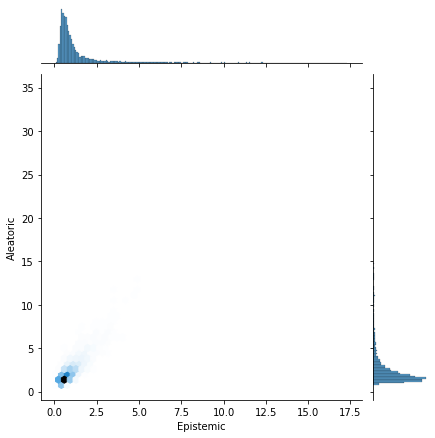

In [14]:
sns.jointplot(x = np.sqrt(cnn_epistemic[:, 0]), y = np.sqrt(cnn_aleatoric[:, 0]), kind = 'hex')
plt.xlabel('Epistemic')
plt.ylabel('Aleatoric')
plt.show()

## Augmented CNN Ensemble of Ensembles

In [12]:
def aug_array(arr, rot=True):
    length = arr.shape[0]
    aug_arr = np.concatenate([arr]*4, axis=0)
    if rot:
        for k in range(4):
            aug_arr[k*length:(k+1)*length] = np.rot90(aug_arr[k*length:(k+1)*length], axes=(1, 2), k=k)
    return aug_arr

In [ ]:
aug_cnn_ensemble_mu = np.zeros((n_models, input_test['REFL_COM_curr'].shape[0], 2))
aug_cnn_ensemble_sigma = np.zeros((n_models, input_test['REFL_COM_curr'].shape[0], 2))

for model_seed in range(n_models):
    
    _model = CNN_model(
        filters=[32, 32, 64, 64, 128],
        kernel_sizes=[3, 3, 3, 3, 3],
        conv_2d_activation='relu',
        pool_sizes=[2, 2, 2, 2, 1],
        dense_activation='relu',
        lr=0.000628345,
        optimizer='nadam',
        metrics=[],
        batch_size=19,
        epochs=10
    )
    _ensemble_pred = np.zeros((n_splits, input_test['REFL_COM_curr'].shape[0], 2))
    
    for data_seed in range(n_splits):
        
        gsp = GroupShuffleSplit(n_splits=n_splits, random_state = flat_seed, train_size=0.885)
        splits = list(gsp.split(input_train_full["REFL_COM_curr"], groups=input_train_full['date']))
        train_index, val_index = splits[data_seed]
        input_train, input_val = input_train_full.isel(p=train_index), input_train_full.isel(p=val_index)
        output_train, output_val = output_train_full.isel(p=train_index), output_train_full.isel(p=val_index)
        
        x_scaler, y_scaler = ImageScaler(), StandardScaler()
        input_train_norm = x_scaler.fit_transform(input_train["REFL_COM_curr"].values)
        input_val_norm = x_scaler.transform(input_val["REFL_COM_curr"].values)
        input_test_norm = x_scaler.transform(input_test["REFL_COM_curr"].values)
        
        output_train_norm = y_scaler.fit_transform(output_train.values)
        output_val_norm = y_scaler.transform(output_val.values)
        output_test_norm = y_scaler.transform(output_test.values)
        
        aug_input_train_norm = aug_array(input_train_norm)
        aug_output_train_norm = aug_array(output_train_norm, rot=False)
        
        model = copy.deepcopy(_model)
        
        history = model.fit(
            x = aug_input_train_norm,
            y = aug_output_train_norm,
            xv = input_val_norm,
            yv = output_val_norm
        )
        
        _ensemble_pred[data_seed] = y_scaler.inverse_transform(model.predict(input_test_norm))
        
        del model
        tf.keras.backend.clear_session()
        gc.collect()
        
    aug_cnn_ensemble_mu[model_seed] = np.mean(_ensemble_pred, 0)
    aug_cnn_ensemble_sigma[model_seed] = np.var(_ensemble_pred, 0)

  1/195 [..............................] - ETA: 19s

In [ ]:
aug_cnn_aleatoric = np.mean(aug_cnn_ensemble_sigma, 0)
aug_cnn_epistemic = np.var(aug_cnn_ensemble_mu, 0)

In [ ]:
print(aug_cnn_epistemic.mean() ** (1/2), aug_cnn_aleatoric.mean() ** (1/2))

In [ ]:
sns.jointplot(x = np.sqrt(aug_cnn_epistemic[:, 0]), y = np.sqrt(aug_cnn_aleatoric[:, 0]), kind = 'hex')
plt.xlabel('Epistemic')
plt.ylabel('Aleatoric')
plt.show()

## RICNN Ensemble of Ensembles

In [ ]:
ricnn_ensemble_mu = np.zeros((n_models, input_test['REFL_COM_curr'].shape[0], 2))
ricnn_ensemble_sigma = np.zeros((n_models, input_test['REFL_COM_curr'].shape[0], 2))

for model_seed in range(n_models):
    
    _model = gdl_model(
        filters=[32, 32, 64, 64, 128],
        kernel_sizes=[3, 3, 3, 3, 3],
        conv_2d_activation='relu',
        pool_sizes=[2, 2, 2, 2, 1],
        dense_activation='relu',
        rot_inv=4,
        lr=0.000628345,
        optimizer='nadam',
        metrics=[],"
        batch_size=19,
        epochs=10
    )
    _ensemble_pred = np.zeros((n_splits, input_test['REFL_COM_curr'].shape[0], 2))
    
    for data_seed in range(n_splits):
        
        gsp = GroupShuffleSplit(n_splits=n_splits, random_state = flat_seed, train_size=0.885)
        splits = list(gsp.split(input_train_full["REFL_COM_curr"], groups=input_train_full['date']))
        train_index, val_index = splits[data_seed]
        input_train, input_val = input_train_full.isel(p=train_index), input_train_full.isel(p=val_index)
        output_train, output_val = output_train_full.isel(p=train_index), output_train_full.isel(p=val_index)
        
        x_scaler, y_scaler = ImagedScaler(), StandardScaler()
        input_train_norm = x_scaler.fit_transform(input_train["REFL_COM_curr"])
        input_val_norm = x_scaler.transform(input_val["REFL_COM_curr"])
        input_test_norm = x_scaler.transform(input_test["REFL_COM_curr"])
        
        output_train_norm = y_scaler.fit_transform(output_train)
        output_val_norm = y_scaler.transform(output_val)
        output_test_norm = y_scaler.transform(output_test)
        
        model = copy.deepcopy(_model)
        
        history = model.fit(
            x = input_train_norm,
            y = output_train_norm,
            xv = input_val_norm,
            yv = output_val_norm
        )
        
        _ensemble_pred[data_seed] = y_scaler.inverse_transform(model.predict(input_test_norm))
        
        del model
        tf.keras.backend.clear_session()
        gc.collect()
        
    ricnn_ensemble_mu[model_seed] = np.mean(_ensemble_pred, 0)
    ricnn_ensemble_sigma[model_seed] = np.var(_ensemble_pred, 0)

In [ ]:
ricnn_aleatoric = np.mean(ricnn_ensemble_sigma, 0)
ricnn_epistemic = np.var(ricnn_ensemble_mu, 0)

In [ ]:
print(ricnn_epistemic.mean() ** (1/2), ricnn_aleatoric.mean() ** (1/2))

In [ ]:
sns.jointplot(x = np.sqrt(ricnn_epistemic[:, 0]), y = np.sqrt(ricnn_aleatoric[:, 0]), kind = 'hex')
plt.xlabel('Epistemic')
plt.ylabel('Aleatoric')
plt.show()